In [1]:
import numpy as np
import pandas as pd
import pickle
import os

base_path = "/kaggle/input/wesad-full-dataset/WESAD/"
subject_ids = [f"S{i}" for i in range(2, 18)]  # S2 to S17
all_subjects_dfs = []

for subject_id in subject_ids:
    txt_file = f"{base_path}{subject_id}/{subject_id}_respiban.txt"
    pkl_file = f"{base_path}{subject_id}/{subject_id}.pkl"
    
    if not os.path.exists(txt_file) or not os.path.exists(pkl_file):
        print(f"Skipping {subject_id} - files not found")
        continue
    
    try:
        # Load ECG
        ecg_data = np.loadtxt(txt_file)
        ecg_raw = ecg_data[:, 2]  # Column 2 = ECG
        
        # Load labels
        with open(pkl_file, "rb") as f:
            labels = pickle.load(f, encoding="latin1")["label"]
        
        # Ensure equal lengths
        min_length = min(len(ecg_raw), len(labels))
        ecg_raw = ecg_raw[:min_length]
        labels = labels[:min_length]
        
        # Convert to mV
        ecg_mv = ((ecg_raw / 65536) - 0.5) * 3.0
        
        # Create DataFrame
        df = pd.DataFrame({
            "timestamp": np.arange(min_length) / 700,
            "ecg_mv": ecg_mv,
            "label": labels,
            "subject_id": subject_id
        })
        all_subjects_dfs.append(df)
        print(f"Processed {subject_id} | ECG: {len(ecg_raw)} | Labels: {len(labels)}")
        
    except Exception as e:
        print(f"Error processing {subject_id}: {str(e)}")

if all_subjects_dfs:
    combined_df = pd.concat(all_subjects_dfs, ignore_index=True)
    print(f"\nSuccess! Combined DataFrame shape: {combined_df.shape}")
    print("Label distribution:")
    print(combined_df["label"].value_counts())
else:
    print("\nNo valid data processed.")

Processed S2 | ECG: 4255300 | Labels: 4255300
Processed S3 | ECG: 4545100 | Labels: 4545100
Processed S4 | ECG: 4496100 | Labels: 4496100
Processed S5 | ECG: 4380600 | Labels: 4380600
Processed S6 | ECG: 4949700 | Labels: 4949700
Processed S7 | ECG: 3666600 | Labels: 3666600
Processed S8 | ECG: 3826200 | Labels: 3826200
Processed S9 | ECG: 3656100 | Labels: 3656100
Processed S10 | ECG: 3847200 | Labels: 3847200
Processed S11 | ECG: 3663100 | Labels: 3663100
Skipping S12 - files not found
Processed S13 | ECG: 3875900 | Labels: 3875900
Processed S14 | ECG: 3883600 | Labels: 3883600
Processed S15 | ECG: 3676400 | Labels: 3676400
Processed S16 | ECG: 3941700 | Labels: 3941700
Processed S17 | ECG: 4144000 | Labels: 4144000

Success! Combined DataFrame shape: (60807600, 4)
Label distribution:
label
0    27654897
1    12327702
4     8264199
2     6976201
3     3902501
7      576802
6      552998
5      552300
Name: count, dtype: int64


In [2]:
import numpy as np
import pandas as pd

# Assuming combined_df is already loaded
valid_df = combined_df[combined_df["label"].isin([1, 2, 3])].copy()
valid_df["binary_label"] = np.where(valid_df["label"] == 2, 1, 0)

# Get the counts
binary_counts = valid_df["binary_label"].value_counts().sort_index()

# Format the output
output = f"Binary Label Distribution:\n" + \
         f"0    {binary_counts[0]:>8}  # Non-stress (baseline + amusement)\n" + \
         f"1    {binary_counts[1]:>8}  # Stress\n" + \
         f"Name: binary_label, dtype: int64"

print(output)

Binary Label Distribution:
0    16230203  # Non-stress (baseline + amusement)
1     6976201  # Stress
Name: binary_label, dtype: int64


Sample Data:
         timestamp    ecg_mv  label subject_id  binary_label
214583  306.547143 -0.049438      1         S2             0
214584  306.548571 -0.054886      1         S2             0
214585  306.550000 -0.055710      1         S2             0
214586  306.551429 -0.058640      1         S2             0
214587  306.552857 -0.066422      1         S2             0


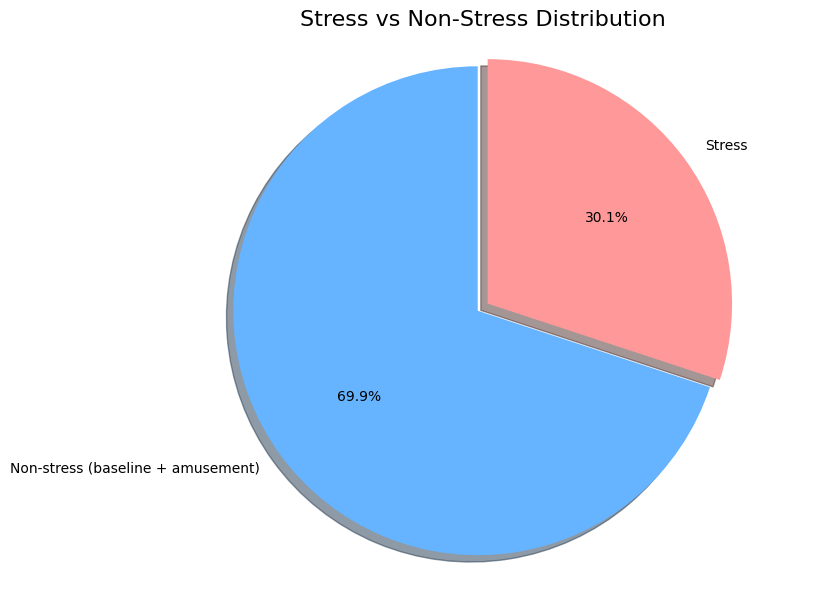

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Display the first 5 rows of the DataFrame
print("Sample Data:")
print(valid_df.head())

# 2. Create the pie chart
plt.figure(figsize=(8, 6))


# Define labels and colors
labels = ['Non-stress (baseline + amusement)', 'Stress']
colors = ['#66b3ff', '#ff9999']
explode = (0.05, 0)  # Explode the 1st slice

plt.pie(binary_counts, 
        labels=labels, 
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=explode,
        shadow=True)

plt.title('Stress vs Non-Stress Distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as circle
plt.tight_layout()
plt.show()


                WINDOW STATISTICS                 

Total windows created: 534

Label distribution:
Non-stress (0): 377 windows (70.6%)
Stress (1):     157 windows (29.4%)

Class ratio: 2.40:1 (Non-stress:Stress)


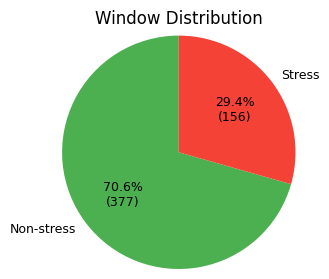

In [4]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def create_labeled_windows(df, window_sec=60, sample_rate=700, min_agreement=0.75):
    """
    Create labeled ECG windows from continuous data
    
    Parameters:
        df: Input DataFrame with ECG data and labels
        window_sec: Window length in seconds
        sample_rate: Sampling rate in Hz
        min_agreement: Minimum agreement threshold for label assignment
        
    Returns:
        windows: ECG signal windows
        labels: Corresponding labels
    """
    window_size = window_sec * sample_rate
    windows = []
    labels = []
    
    for subject, subject_df in df.groupby('subject_id'):
        ecg_signal = subject_df['ecg_mv'].values
        binary_labels = subject_df['binary_label'].values
        
        for start in range(0, len(subject_df) - window_size + 1, window_size):
            end = start + window_size
            window_labels = binary_labels[start:end]
            
            label_counts = Counter(window_labels)
            majority_label, majority_count = label_counts.most_common(1)[0]
            agreement = majority_count / window_size
            
            if agreement >= min_agreement:
                windows.append(ecg_signal[start:end])
                labels.append(majority_label)
    
    return np.array(windows), np.array(labels)

# Create windows
windows, labels = create_labeled_windows(valid_df)

# Calculate statistics
total_windows = len(windows)
label_counts = pd.Series(labels).value_counts().sort_index()
label_percent = label_counts / total_windows * 100

# 1. Text Output
print(f"\n{'='*50}")
print(f"{'WINDOW STATISTICS':^50}")
print(f"{'='*50}")
print(f"\nTotal windows created: {total_windows:,}")
print("\nLabel distribution:")
print(f"Non-stress (0): {label_counts.get(0, 0):,} windows ({label_percent.get(0, 0):.1f}%)")
print(f"Stress (1):     {label_counts.get(1, 0):,} windows ({label_percent.get(1, 0):.1f}%)")
print(f"\nClass ratio: {label_counts.get(0, 1)/label_counts.get(1, 1):.2f}:1 (Non-stress:Stress)")


# Pie Chart
plt.subplot(1, 3, 1)
plt.pie(label_counts, 
        labels=['Non-stress', 'Stress'],
        colors=['#4CAF50', '#F44336'],
        radius=2,
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*total_windows):,})',
        startangle=90,
        textprops={'fontsize': 9})
plt.title('Window Distribution', pad=40)




plt.show()

In [5]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 15.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install entropy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for entropy: filename=entropy-0.1.5-py3-none-any.whl size=7177 sha256=9c9384f4ed928b0804c852b0dc2602b1b995bf4e9eac2ef5adab0afe5ad808d0
  Stored in directory: /root/.cache/pip/wheels/7b/ae/a5/3981344d7be76f408fc6c9c280cb1706f033d4c1018913897a
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d51572795138ae8d953008a22c284b7843a7f2e0c5d0b0321fd6e860ed34adb5
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built entropy docopt
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import neurokit2 as nk
from tqdm import tqdm

def calculate_hr(peaks, sampling_rate):
    """Robust heart rate calculation"""
    if len(peaks['ECG_R_Peaks']) < 2:
        return np.nan
    rr_intervals = np.diff(peaks['ECG_R_Peaks']) / sampling_rate
    return float(60 / np.mean(rr_intervals))

def extract_ecg_features(ecg_signal, sampling_rate=700):
    """Optimized feature extraction with guaranteed numeric output"""
    try:
        # 1. Preprocessing
        cleaned = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
        
        # 2. Peak detection
        peaks = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate, method="kalidas2017")[1]
        
        # 3. Feature extraction
        features = {
            # Basic ECG stats (always available)
            'ecg_mean': float(np.mean(cleaned)),
            'ecg_std': float(np.std(cleaned)),
            'ecg_skew': float(pd.Series(cleaned).skew()),
            'ecg_kurtosis': float(pd.Series(cleaned).kurtosis()),
            
            # Heart rate (fixed calculation)
            'hr_mean': calculate_hr(peaks, sampling_rate),
        }
        
        # 4. HRV features (only if enough peaks)
        if len(peaks['ECG_R_Peaks']) > 4:
            hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate)
            hrv_freq = nk.hrv_frequency(peaks, sampling_rate=sampling_rate)
            
            features.update({
                'hrv_sdnn': float(hrv_time['HRV_SDNN'].iloc[0]),
                'hrv_rmssd': float(hrv_time['HRV_RMSSD'].iloc[0]),
                'hrv_pnn50': float(hrv_time['HRV_pNN50'].iloc[0]),
                'hrv_hf': float(hrv_freq['HRV_HF'].iloc[0]),
                'hrv_lf': float(hrv_freq['HRV_LF'].iloc[0]),
                'hrv_lfhf': float(hrv_freq['HRV_LFHF'].iloc[0])
            })
        
        return features
        
    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        return None

def process_all_windows(windows, labels, sampling_rate=700):
    """
    Process all ECG windows and create feature matrix
    
    Parameters:
        windows (list): List of ECG window arrays
        labels (array): Corresponding labels
        sampling_rate (int): Sampling frequency in Hz
        
    Returns:
        DataFrame: Features with labels
    """
    features = []
    for i in tqdm(range(len(windows)), desc="Extracting Features"):
        feat = extract_ecg_features(windows[i], sampling_rate)
        if feat is not None:  # Only append if feature extraction succeeded
            feat['label'] = labels[i]
            features.append(feat)
    
    return pd.DataFrame(features).fillna(method='ffill')

# Example usage (assuming you have windows and labels defined)
if __name__ == "__main__":
    # You'll need to define these variables first:
    # windows = [your_ecg_data_arrays]
    # labels = [corresponding_labels]
    
    feature_df = process_all_windows(windows, labels)

    # Display final results
    print("\n" + "="*50)
    print(f"{'FINAL FEATURE EXTRACTION RESULTS':^50}")
    print("="*50)
    print(f"\nTotal windows processed: {len(feature_df)}")
    print(f"Success rate: {100*(1-feature_df.isna().mean().mean()):.1f}%")
    print("\nLabel distribution:")
    print(feature_df['label'].value_counts())
    print("\nFeature preview (no NaN values):")
    print(feature_df.dropna().head(3).to_string(float_format="%.3f"))

Extracting Features: 100%|██████████| 534/534 [00:13<00:00, 38.16it/s]


         FINAL FEATURE EXTRACTION RESULTS         

Total windows processed: 534
Success rate: 100.0%

Label distribution:
label
0    377
1    157
Name: count, dtype: int64

Feature preview (no NaN values):
   ecg_mean  ecg_std  ecg_skew  ecg_kurtosis  hr_mean  hrv_sdnn  hrv_rmssd  hrv_pnn50  hrv_hf  hrv_lf  hrv_lfhf  label
0    -0.000    0.126    -0.382         2.999   95.238    50.507     25.941      4.301   0.009   0.041     4.409      0
1     0.001    0.113    -0.884         2.722   90.051    51.539     24.597      3.371   0.012   0.015     1.265      0
2    -0.000    0.116    -0.580         0.733   95.478    29.838     10.276      0.000   0.003   0.008     2.468      0



<ipython-input-7-b16b02a09358>:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.DataFrame(features).fillna(method='ffill')


In [8]:
import pandas as pd

# Display first 5 rows with formatted floats
pd.set_option('display.float_format', '{:.3f}'.format)
display(feature_df.head().style.set_caption("First 5 Windows with Extracted Features"))

,ecg_mean,ecg_std,ecg_skew,ecg_kurtosis,hr_mean,hrv_sdnn,hrv_rmssd,hrv_pnn50,hrv_hf,hrv_lf,hrv_lfhf,label
0,-0.000123,0.125950,-0.381739,2.999495,95.238095,50.506749,25.941029,4.301075,0.009357,0.041259,4.409306,0
1,0.000916,0.113400,-0.884450,2.721702,90.050590,51.538806,24.597408,3.370787,0.011746,0.014863,1.265335,0
2,-0.000061,0.115715,-0.579731,0.732762,95.477630,29.837883,10.275981,0.000000,0.003277,0.008087,2.467865,0
3,-0.000244,0.120351,-0.457743,0.324390,101.704766,17.220747,6.587345,0.000000,0.005151,0.024037,4.666245,0
4,0.000121,0.123744,-0.162924,1.746068,99.569403,58.718464,31.002942,6.122449,0.011697,0.048583,4.153403,0


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Separate data into stress (1) and non-stress (0)
stress = feature_df[feature_df['label'] == 1]
non_stress = feature_df[feature_df['label'] == 0]

# Split each class separately (70% train, 30% test)
X_stress_train, X_stress_test, y_stress_train, y_stress_test = train_test_split(
    stress.drop(columns=['label']), 
    stress['label'], 
    test_size=0.3, 
    random_state=42
)

X_non_stress_train, X_non_stress_test, y_non_stress_train, y_non_stress_test = train_test_split(
    non_stress.drop(columns=['label']), 
    non_stress['label'], 
    test_size=0.3, 
    random_state=42
)

# Combine the splits
X_train = pd.concat([X_stress_train, X_non_stress_train], axis=0)
y_train = pd.concat([y_stress_train, y_non_stress_train], axis=0)

X_test = pd.concat([X_stress_test, X_non_stress_test], axis=0)
y_test = pd.concat([y_stress_test, y_non_stress_test], axis=0)

# Verify distribution
print("Original Class Counts:")
print(f"Non-stress (0): {len(non_stress)}")
print(f"Stress (1): {len(stress)}")

print("\nTrain Set Distribution:")
print(y_train.value_counts())
print(f"Ratio: {y_train.mean():.3f}")

print("\nTest Set Distribution:")
print(y_test.value_counts())
print(f"Ratio: {y_test.mean():.3f}")

# Shuffle the datasets (important for training)
X_train = X_train.sample(frac=1, random_state=42)
y_train = y_train.loc[X_train.index]

X_test = X_test.sample(frac=1, random_state=42)
y_test = y_test.loc[X_test.index]

Original Class Counts:
Non-stress (0): 377
Stress (1): 157

Train Set Distribution:
label
0    263
1    109
Name: count, dtype: int64
Ratio: 0.293

Test Set Distribution:
label
0    114
1     48
Name: count, dtype: int64
Ratio: 0.296


In [10]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE with 1:1 ratio
smote = SMOTE(
    sampling_strategy=1.0,  # Force exact balance (263:263)
    k_neighbors=5,          # Optimal for ECG feature space
    random_state=42
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify
print("\nAfter SMOTE:")
print(pd.Series(y_train_smote).value_counts())
print(f"New ratio: {y_train_smote.mean():.1%}")


After SMOTE:
label
0    263
1    263
Name: count, dtype: int64
New ratio: 50.0%


Model Accuracy: 90.74%

Detailed Report:
              precision    recall  f1-score   support

  Non-stress       0.95      0.92      0.93       114
      Stress       0.82      0.88      0.85        48

    accuracy                           0.91       162
   macro avg       0.88      0.90      0.89       162
weighted avg       0.91      0.91      0.91       162



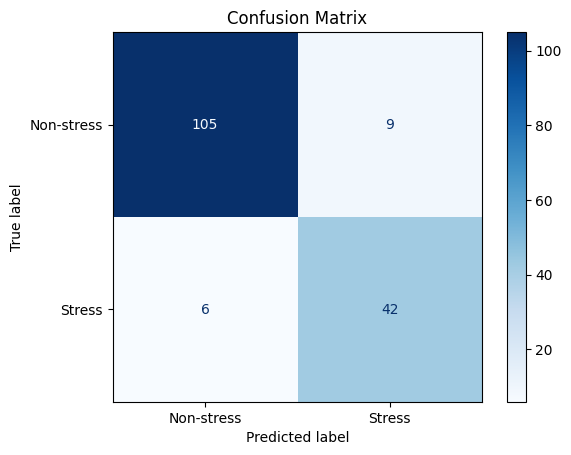

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

model = RandomForestClassifier(
    n_estimators=150,
    max_depth=9,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_smote, y_train_smote)
#model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=["Non-stress", "Stress"]))

# 3. Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                      display_labels=["Non-stress", "Stress"],
                                      cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

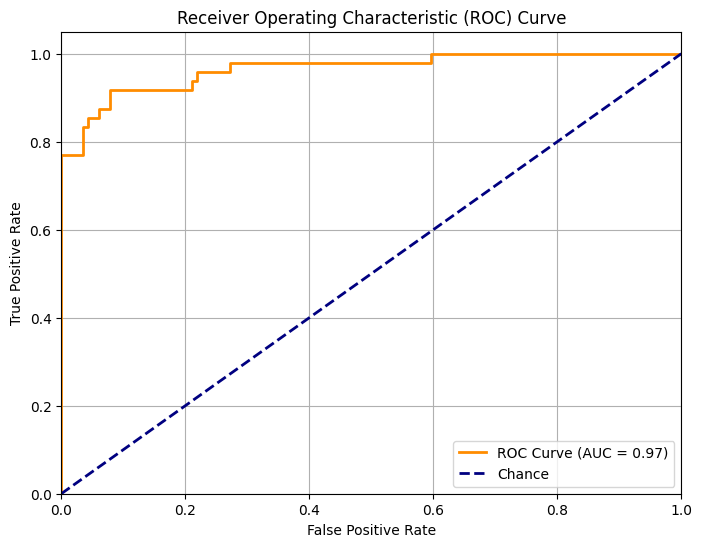

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Predict probabilities for the positive class (Stress = 1)
y_proba = model.predict_proba(X_test)[:, 1]

# 2. Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 3. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


XGBoost Model Accuracy: 89.51%

Detailed Classification Report:
              precision    recall  f1-score   support

  Non-stress       0.94      0.90      0.92       114
      Stress       0.79      0.88      0.83        48

    accuracy                           0.90       162
   macro avg       0.87      0.89      0.88       162
weighted avg       0.90      0.90      0.90       162



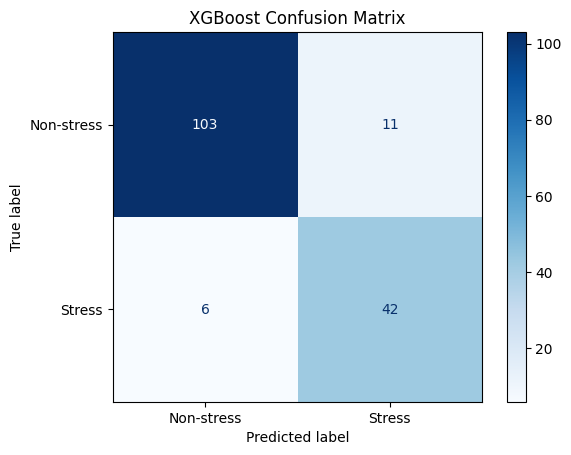

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# 1. Initialize and train XGBoost with balanced classes
xgb_model = XGBClassifier(
    max_depth=5,               # Control tree depth
    learning_rate=0.1,         # Shrinkage to prevent overfitting
    n_estimators=150,          # Number of boosting rounds
    scale_pos_weight=2.375,    # Counter class imbalance (48 stress / 114 non-stress ≈ 2.375)
    objective='binary:logistic',
    eval_metric='logloss',     # Alternative: 'auc'
    random_state=42
)

# Train the model with SMOTE-augmented data
xgb_model.fit(X_train_smote, y_train_smote)

# 2. Evaluate the model
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb:.2%}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["Non-stress", "Stress"]))

# 3. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, 
                                         display_labels=["Non-stress", "Stress"],
                                         cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()



Decision Tree Accuracy: 86.42%

Detailed Report:
              precision    recall  f1-score   support

  Non-stress       0.91      0.89      0.90       114
      Stress       0.76      0.79      0.78        48

    accuracy                           0.86       162
   macro avg       0.84      0.84      0.84       162
weighted avg       0.87      0.86      0.86       162



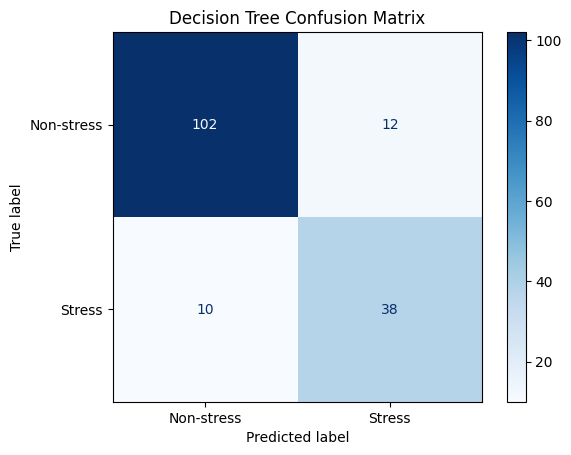

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(
    max_depth=10,                # Limit tree depth to 5
    criterion='entropy',        # Use entropy for information gain
    class_weight='balanced',    # Handle class imbalance
    random_state=42
)
dt_model.fit(X_train_smote, y_train_smote)
# 2. Evaluate
y_pred = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree Accuracy: {accuracy:.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred, target_names=["Non-stress", "Stress"]))

# 3. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Non-stress", "Stress"],
    cmap='Blues'
)
plt.title("Decision Tree Confusion Matrix")
plt.show()